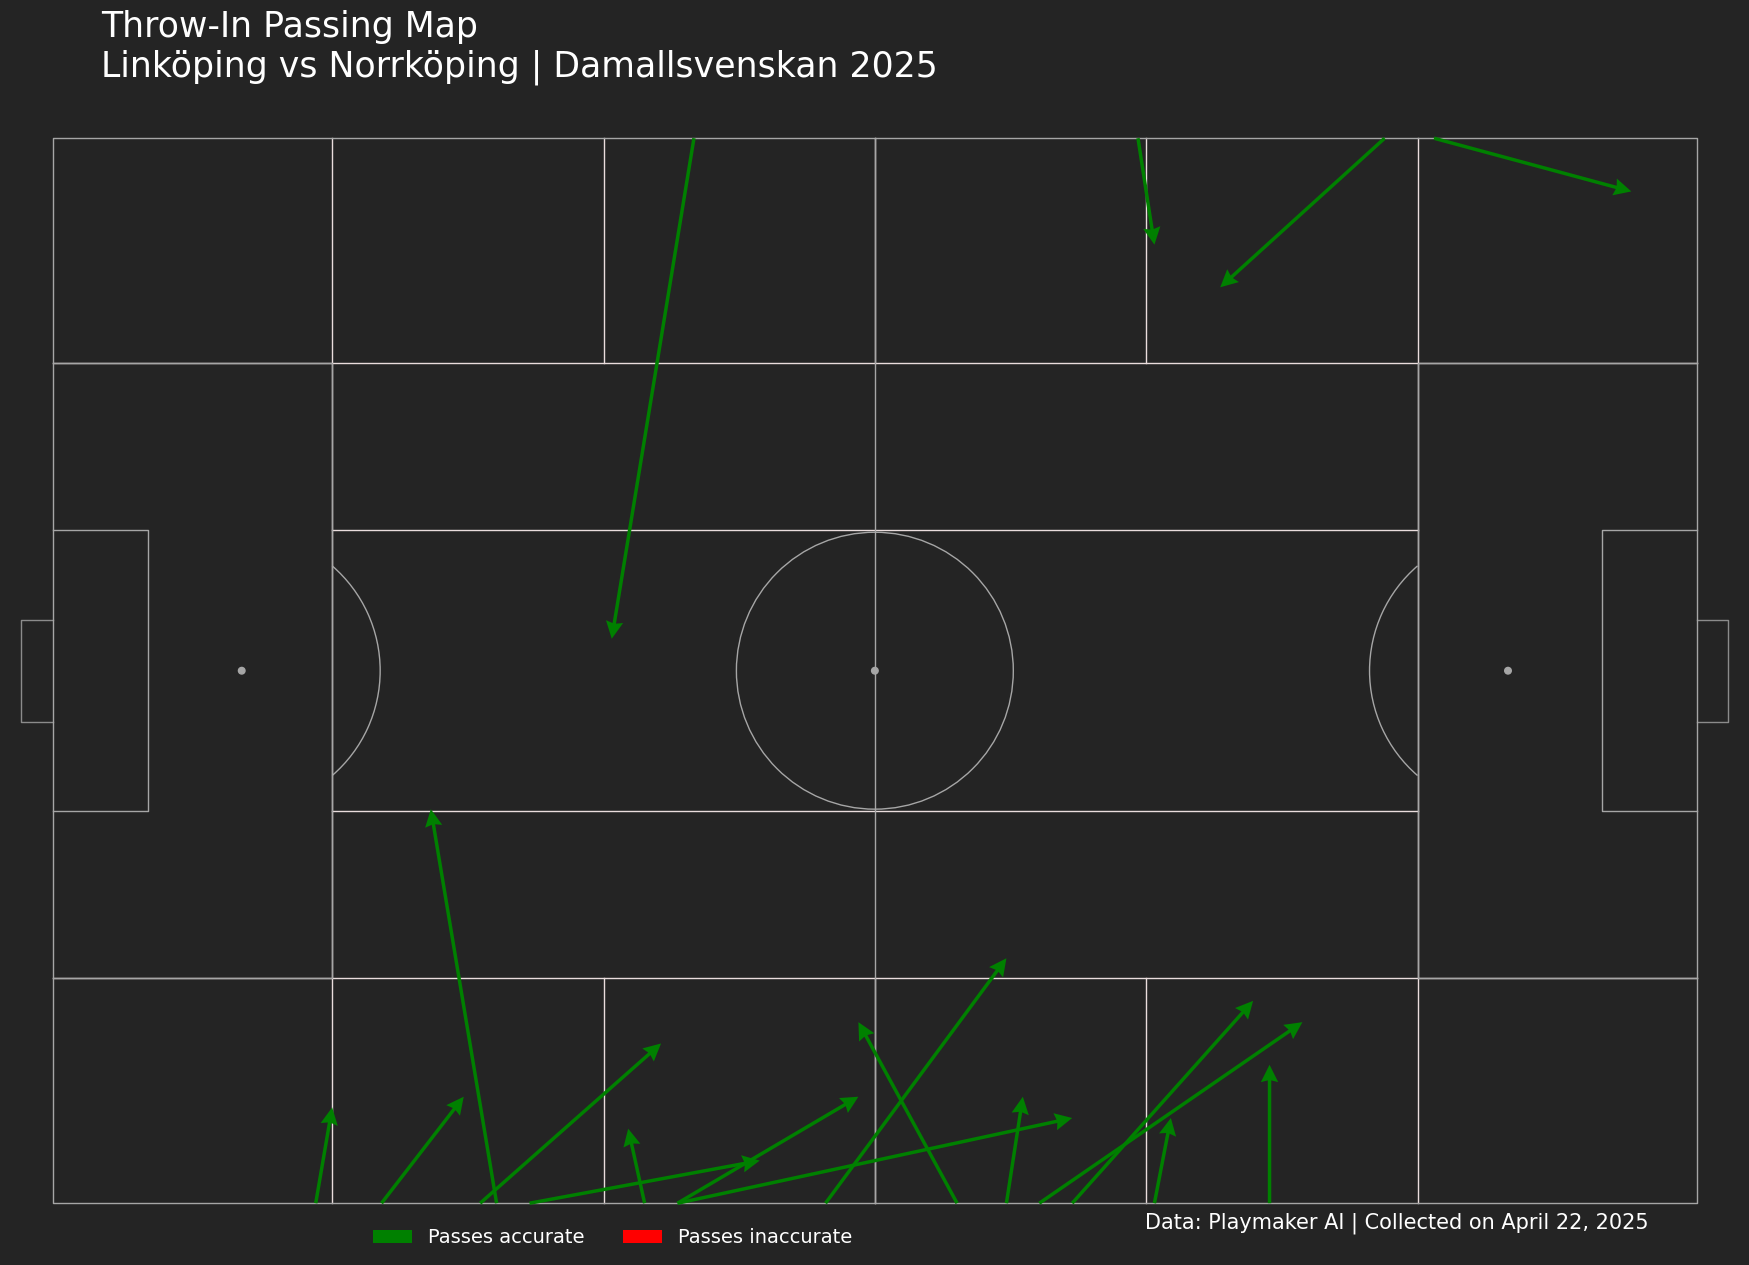

In [7]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.patches import Patch
from matplotlib.offsetbox import OffsetImage, AnnotationBbox
from datetime import datetime

# Load the CSV and filter for Throw Ins
df = pd.read_csv("Dashboard _ PlaymakerAI (1).csv")
df = df[df['throw_in'] == True]

# Set up pitch
pitch = Pitch(positional=True, pitch_type='opta', pad_bottom=0.5, pad_top=5,
              pitch_color='#242424', line_color='#a6a6a6', linewidth=1,
              half=False, goal_type='box', goal_alpha=0.8)

fig, ax = pitch.draw(figsize=(18, 12))

# Plot accurate/inaccurate throw-in passes
for _, row in df.iterrows():
    if row['action'] == 'Passes accurate':
        pitch.arrows(row['xpos'], row['ypos'], row['xdest'], row['ydest'],
                     width=2.5, zorder=2, headwidth=5, headlength=5, color='green', ax=ax)
    elif row['action'] == 'Passes (inaccurate)':
        pitch.arrows(row['xpos'], row['ypos'], row['xdest'], row['ydest'],
                     width=2.5, zorder=2, headwidth=5, headlength=5, color='red', ax=ax)

# Set background color
fig.set_facecolor('#242424')

# Title
fig.text(0.07, 1.05, "Throw-In Passing Map\nLinköping vs Norrköping | Damallsvenskan 2025",
         fontsize=25, color="white", ha='left', va='top')

# Legend
legend_elements = [
    Patch(facecolor='green', edgecolor='none', label='Passes accurate'),
    Patch(facecolor='red', edgecolor='none', label='Passes inaccurate')
]
ax.legend(handles=legend_elements,
          loc='lower left',
          bbox_to_anchor=(0.2, -0.05),
          ncol=2, frameon=False, fontsize=14, labelcolor='white')

# Bottom right credit
today = datetime.today().strftime('%B %d, %Y')
fig.text(0.93, 0.035, f'Data: Playmaker AI | Collected on {today}',
         fontsize=15, color='white', ha='right')

# Optional: Add logo
# logo = plt.imread("Outswinger FC (3).png")
# imagebox = OffsetImage(logo, zoom=0.09)
# ab = AnnotationBbox(imagebox, (0.1, 0.01), frameon=False, xycoords='figure fraction', boxcoords="axes fraction")
# ax.add_artist(ab)

# Save
plt.savefig("Throw_In_Passing_Map.png", dpi=500, bbox_inches='tight', facecolor='#242424')
plt.show()


In [20]:
import pandas as pd

# Load and clean data
df = pd.read_csv("Dashboard _ PlaymakerAI (1).csv")
df['xt_in_play'] = pd.to_numeric(df['xt_in_play'].astype(str).str.replace(',', '.'), errors='coerce')
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
df = df.sort_values(by=['game', 'start_time']).reset_index(drop=True)

# Find indices of throw-ins that retained possession
throw_in_indices = df[(df['attack_type'] == 'Throw In') & (df['throw_in'] == True)].index

# Calculate sequence lengths after each throw-in
sequence_lengths = []
for idx in throw_in_indices:
    team = df.loc[idx, 'team']
    game = df.loc[idx, 'game']
    chain = df.loc[idx:idx+10]  # look ahead up to 10 actions max
    chain = chain[(chain['team'] == team) & (chain['game'] == game)]
    sequence_lengths.append({
        "start_index": idx,
        "team": team,
        "game": game,
        "sequence_length": len(chain)
    })

# Convert to DataFrame
sequence_lengths_df = pd.DataFrame(sequence_lengths)

# Display the result
print(sequence_lengths_df.to_string(index=False))

# Optional: Save to CSV
sequence_lengths_df.to_csv("throw_in_sequence_lengths.csv", index=False)


 start_index      team                       game  sequence_length
          84 Linköping Linköping - IFK Norrköping               11
          90 Linköping Linköping - IFK Norrköping               11
          91 Linköping Linköping - IFK Norrköping               11
         286 Linköping Linköping - IFK Norrköping               11
         428 Linköping Linköping - IFK Norrköping               11
         429 Linköping Linköping - IFK Norrköping               11
         460 Linköping Linköping - IFK Norrköping               11
         461 Linköping Linköping - IFK Norrköping               11
         463 Linköping Linköping - IFK Norrköping               11
         465 Linköping Linköping - IFK Norrköping               11
         469 Linköping Linköping - IFK Norrköping               11
         497 Linköping Linköping - IFK Norrköping                4
         499 Linköping Linköping - IFK Norrköping                2
         597 Linköping Linköping - IFK Norrköping             

/Users/marclambertes/anaconda3/lib/python3.10/site-packages/pandas/core/arrays/masked.py:60: UserWarning: Pandas requires version '1.3.6' or newer of 'bottleneck' (version '1.3.5' currently installed).
  from pandas.core import (


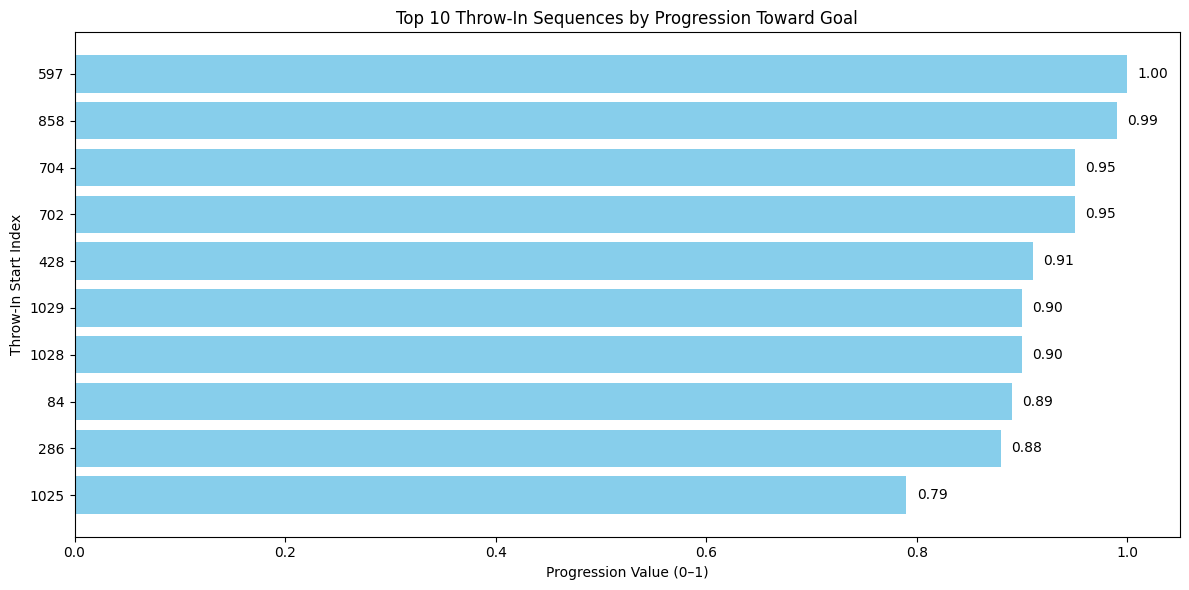

In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# Load and clean data
df = pd.read_csv("Dashboard _ PlaymakerAI (1).csv")
df['xt_in_play'] = pd.to_numeric(df['xt_in_play'].astype(str).str.replace(',', '.'), errors='coerce')
df['start_time'] = pd.to_datetime(df['start_time'], errors='coerce')
df = df.sort_values(by=['game', 'start_time']).reset_index(drop=True)

# Identify throw-ins with possession retained
throw_in_indices = df[(df['attack_type'] == 'Throw In') & (df['throw_in'] == True)].index

# For each throw-in, build chain and calculate progression toward goal
sequence_analysis = []
for idx in throw_in_indices:
    team = df.loc[idx, 'team']
    game = df.loc[idx, 'game']
    
    chain = df.loc[idx:idx+10]
    chain = chain[(chain['team'] == team) & (chain['game'] == game)]
    
    if not chain.empty:
        start_y = chain.iloc[0]['ypos']
        end_y = chain.iloc[-1]['ydest'] if pd.notna(chain.iloc[-1]['ydest']) else chain.iloc[-1]['ypos']
        progression = abs(end_y - start_y)
    else:
        progression = 0

    sequence_analysis.append({
        "start_index": idx,
        "team": team,
        "game": game,
        "sequence_length": len(chain),
        "progression_toward_goal": progression
    })

# Create DataFrame
sequence_value_df = pd.DataFrame(sequence_analysis)

# Normalize progression to value (0 to 1)
max_pitch_y = 100  # Assuming pitch data is 0–100 scale
sequence_value_df['progression_value'] = sequence_value_df['progression_toward_goal'] / max_pitch_y

# --- Visualization: Top 10 Most Valuable Throw-Ins ---
top_sequences = sequence_value_df.sort_values(by='progression_value', ascending=False).head(10)

plt.figure(figsize=(12, 6))
bars = plt.barh(
    top_sequences['start_index'].astype(str), 
    top_sequences['progression_value'], 
    color='skyblue'
)

plt.xlabel("Progression Value (0–1)")
plt.ylabel("Throw-In Start Index")
plt.title("Top 10 Throw-In Sequences by Progression Toward Goal")
plt.gca().invert_yaxis()  # Highest value on top

# Annotate bars
for bar in bars:
    width = bar.get_width()
    plt.text(width + 0.01, bar.get_y() + bar.get_height() / 2,
             f"{width:.2f}", va='center', fontsize=10)

plt.tight_layout()
plt.show()


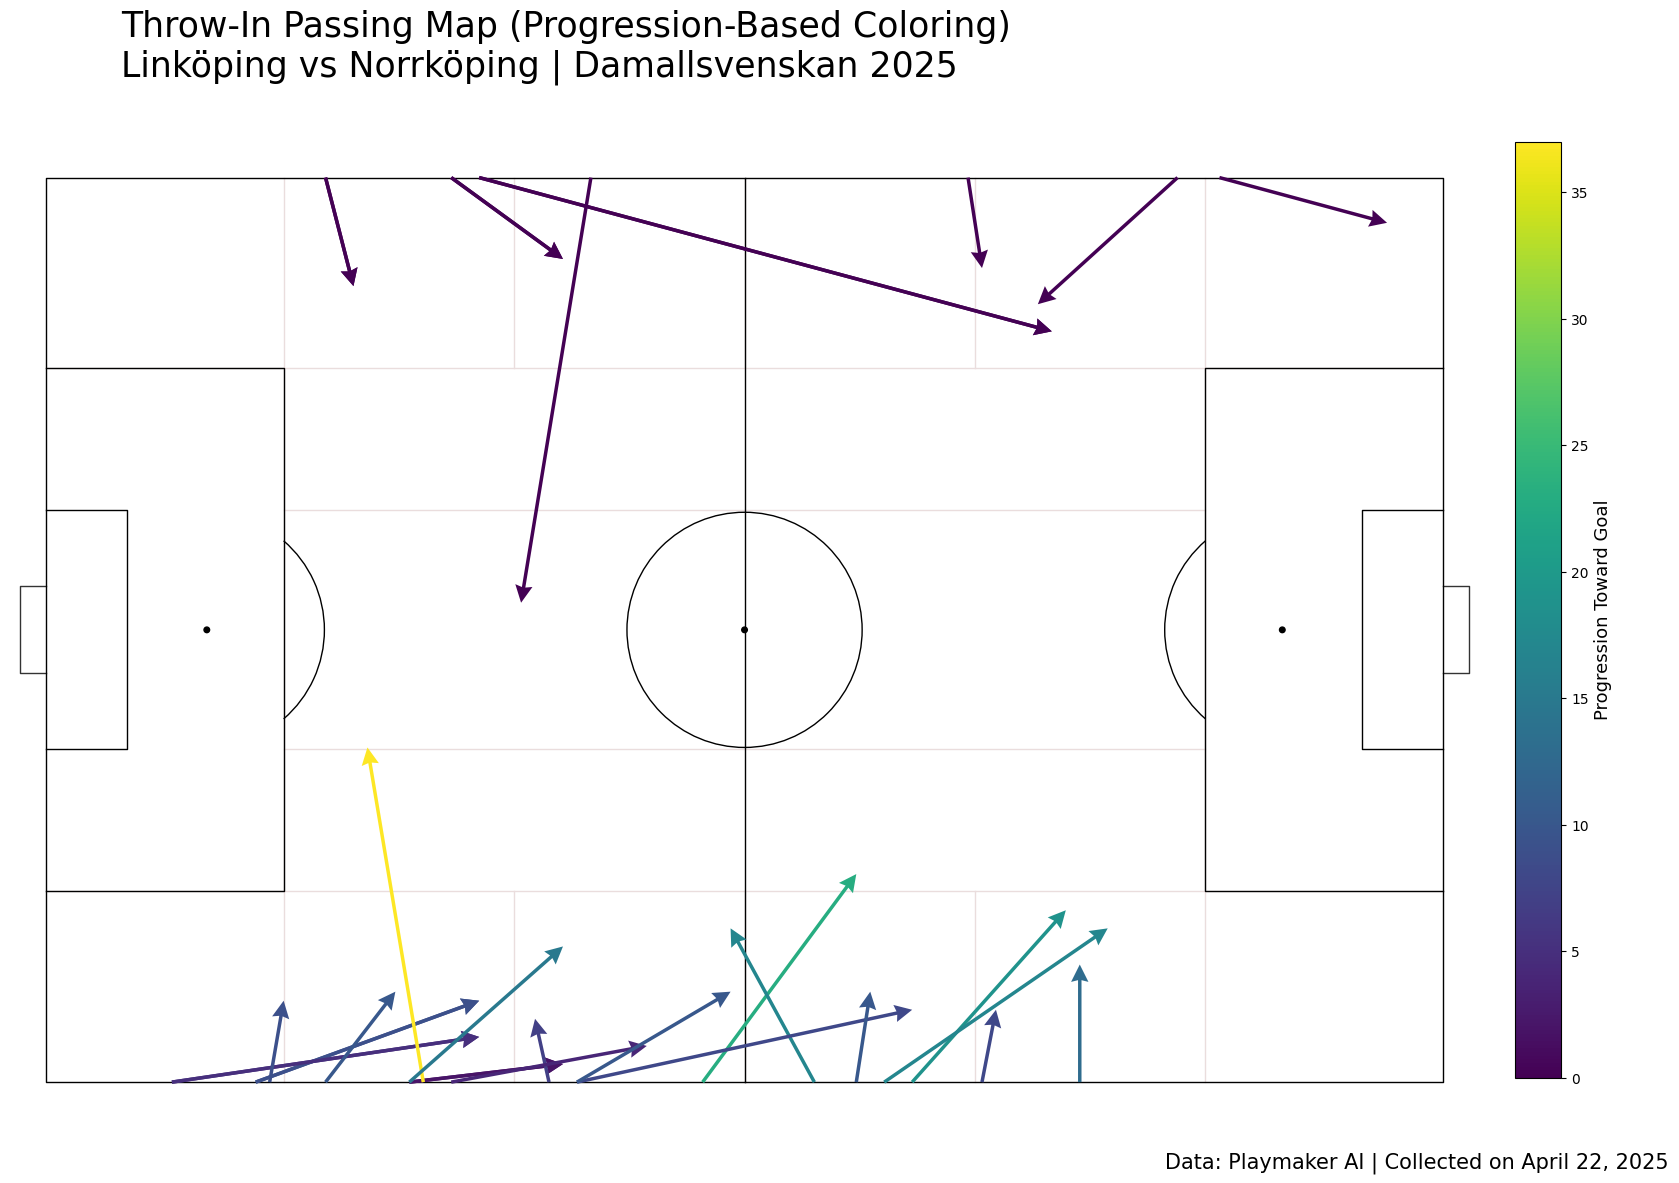

In [5]:
import pandas as pd
import matplotlib.pyplot as plt
from mplsoccer import Pitch
from matplotlib.patches import Patch
from matplotlib.cm import ScalarMappable
from matplotlib.colors import Normalize
from datetime import datetime

# Load the CSV and filter for Throw Ins with value retained
df = pd.read_csv("Dashboard _ PlaymakerAI (1).csv")
df = df[df['throw_in'] == True].copy()

# Calculate progression (toward opponent goal)
df['progression'] = df['ydest'] - df['ypos']  # positive = forward
df['progression'] = df['progression'].clip(lower=0)  # clip backwards passes to 0

# Normalize progression for coloring
norm = Normalize(vmin=0, vmax=df['progression'].max())
cmap = plt.cm.viridis
df['color'] = df['progression'].apply(lambda x: cmap(norm(x)))

# Set up pitch with white background and black lines
pitch = Pitch(positional=True, pitch_type='opta', pad_bottom=0.5, pad_top=5,
              pitch_color='white', line_color='black', linewidth=1,
              half=False, goal_type='box', goal_alpha=0.8)

fig, ax = pitch.draw(figsize=(18, 12))

# Plot arrows with color based on progression
for _, row in df.iterrows():
    pitch.arrows(row['xpos'], row['ypos'], row['xdest'], row['ydest'],
                 width=2.5, zorder=2, headwidth=5, headlength=5, color=row['color'], ax=ax)

# Colorbar for reference
sm = ScalarMappable(cmap=cmap, norm=norm)
cbar = plt.colorbar(sm, ax=ax, pad=0.02, orientation='vertical', shrink=0.8)
cbar.set_label("Progression Toward Goal", color='black', fontsize=13)
cbar.ax.yaxis.set_tick_params(color='black')
plt.setp(plt.getp(cbar.ax.axes, 'yticklabels'), color='black')

# Set figure background to white
fig.set_facecolor('white')

# Title
fig.text(0.07, 1, "Throw-In Passing Map (Progression-Based Coloring)\nLinköping vs Norrköping | Damallsvenskan 2025",
         fontsize=25, color="black", ha='left', va='top')

# Bottom right credit
today = datetime.today().strftime('%B %d, %Y')
fig.text(0.93, 0.035, f'Data: Playmaker AI | Collected on {today}',
         fontsize=15, color='black', ha='right')

# Save and show
plt.savefig("Throw_In_Passing_Map_Progression_WhiteBG.png", dpi=500, bbox_inches='tight', facecolor='white')
plt.show()
